In [1]:
import pickle
import numpy as np
import pandas as pd
from datetime import datetime
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import keras_tuner as kt
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping

from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
with open(r'.\Reviews_Dataset_Splits\X_train.pkl', 'rb') as f:
    X_train = pickle.load(f)

with open(r'.\Reviews_Dataset_Splits\X_val.pkl', 'rb') as f:
    X_val = pickle.load(f)

with open(r'.\Reviews_Dataset_Splits\X_test.pkl', 'rb') as f:
    X_test = pickle.load(f)

with open(r'.\Reviews_Dataset_Splits\y_train.pkl', 'rb') as f:
    y_train = pickle.load(f)

with open(r'.\Reviews_Dataset_Splits\y_val.pkl', 'rb') as f:
    y_val = pickle.load(f)

with open(r'.\Reviews_Dataset_Splits\y_test.pkl', 'rb') as f:
    y_test = pickle.load(f)

y_train = keras.utils.to_categorical(y_train-1, num_classes=5)
y_val = keras.utils.to_categorical(y_val-1, num_classes=5)
y_test = keras.utils.to_categorical(y_test-1, num_classes=5)

with open(r'.\embeddingMatrix_Reviews.pkl', 'rb') as f:
    embedding_matrix = pickle.load(f)

num_tokens = len(embedding_matrix) # total vocabulary +1 or length of embedding matrix
embedding_dim = 300 # dimension of the vector of a single word
MAX_REVIEW_LEN = 250 # maximum words in a review
num_classes = 5

In [4]:
embedding_layer = keras.layers.Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    input_length=MAX_REVIEW_LEN,
    trainable=True)

model = keras.Sequential()
model.add(embedding_layer)

activation = 'relu'
kernel_initializer = 'he_uniform'

model.add(layers.Conv1D(filters=96, kernel_size=5, activation=activation, kernel_initializer=kernel_initializer, padding='same'))
model.add(layers.MaxPooling1D(pool_size=2))

model.add(layers.Conv1D(filters=96, kernel_size=5, activation=activation, kernel_initializer=kernel_initializer, padding='same'))
model.add(layers.Dropout(rate=0.4))
model.add(layers.MaxPooling1D(pool_size=2))

model.add(layers.Conv1D(filters=64, kernel_size=5, activation=activation, kernel_initializer=kernel_initializer, padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(rate=0.2))
model.add(layers.MaxPooling1D(pool_size=2))

model.add(layers.GlobalAveragePooling1D())
model.add(layers.Dense(num_classes, activation='softmax'))

model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [5]:
NUM_EPOCHS = 3
BATCH_SIZE = 128
history = model.fit(X_train, y_train, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_val, y_val))

Epoch 1/3
771/771 [==============================] - 17s 15ms/step - loss: 1.1905 - accuracy: 0.4944 - val_loss: 1.0979 - val_accuracy: 0.5509
Epoch 2/3
771/771 [==============================] - 11s 14ms/step - loss: 0.9078 - accuracy: 0.6351 - val_loss: 1.0701 - val_accuracy: 0.5648
Epoch 3/3
771/771 [==============================] - 11s 14ms/step - loss: 0.6012 - accuracy: 0.7684 - val_loss: 1.1309 - val_accuracy: 0.5968


In [6]:
score = model.evaluate(X_val, y_val, verbose=1)
print("Validation loss: ", score[0])
print("Validation accuracy: ", score[1])

771/771 [==============================] - 2s 2ms/step - loss: 1.1309 - accuracy: 0.5969
Validation loss:  1.1309280395507812
Validation accuracy:  0.5968762636184692


In [7]:
y_prediction = model.predict(X_test)
y_prediction = np.argmax(y_prediction, axis=1)
y_actuals = np.argmax(y_test, axis=1)
#Create confusion matrix and normalizes it over predicted (columns)
result = confusion_matrix(y_actuals, y_prediction , normalize='pred')
print(result)

680/680 [==============================] - 1s 2ms/step
[[0.66560914 0.13116251 0.06000591 0.03182442 0.057096  ]
 [0.19775804 0.67255021 0.15814366 0.07078189 0.0602266 ]
 [0.08481387 0.13542301 0.63316583 0.1920439  0.10211688]
 [0.03003384 0.03925746 0.10877919 0.55829904 0.24791294]
 [0.02178511 0.02160682 0.03990541 0.14705075 0.53264758]]


In [8]:
accuracy_score = metrics.accuracy_score(y_prediction, y_actuals)

print('CNN accuracy is',str('{:04.2f}'.format(accuracy_score*100))+'%')
print('------------------------------------------------')
print('Confusion Matrix:')
print(pd.DataFrame(confusion_matrix(y_actuals, y_prediction)))
print('------------------------------------------------')
print('Classification Report:')
print(classification_report(y_actuals, y_prediction))

CNN accuracy is 60.26%
------------------------------------------------
Confusion Matrix:
      0     1     2     3     4
0  3147   431   203   116   383
1   935  2210   535   258   404
2   401   445  2142   700   685
3   142   129   368  2035  1663
4   103    71   135   536  3573
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.74      0.70      4280
           1       0.67      0.51      0.58      4342
           2       0.63      0.49      0.55      4373
           3       0.56      0.47      0.51      4337
           4       0.53      0.81      0.64      4418

    accuracy                           0.60     21750
   macro avg       0.61      0.60      0.60     21750
weighted avg       0.61      0.60      0.60     21750



In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

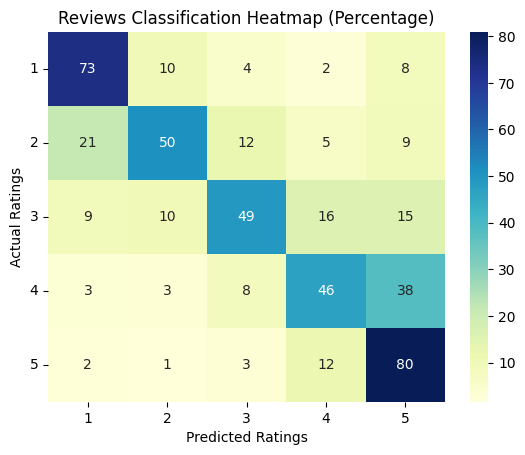

In [10]:
# Create a confusion matrix
confusion_matrix = np.zeros((num_classes, num_classes))
for i in range(len(y_prediction)):
    confusion_matrix[y_actuals[i], y_prediction[i]] += 1

# Normalize the confusion matrix to show percentages
confusion_matrix = 100 * confusion_matrix / confusion_matrix.sum(axis=1, keepdims=True)

lables = [1, 2, 3, 4, 5]
# Create a heatmap with annotation
annot_matrix = np.around(confusion_matrix, 1).astype(int)  # Round percentages to 1 decimal place
ax = sns.heatmap(confusion_matrix, annot=annot_matrix, fmt='d', cmap="YlGnBu", xticklabels=lables, yticklabels=lables)

# Set the title and axis labels
plt.title("Reviews Classification Heatmap (Percentage)")
plt.xlabel("Predicted Ratings")
plt.ylabel("Actual Ratings")

# Rotate the x-axis labels for better visibility
plt.yticks(rotation=0)

# Display the heatmap
plt.show()

In [11]:
from tensorflow.keras.models import load_model
import os

# Save the model
model_save_path = 'SavedModels/CNN_BestModel.h5'
model.save(model_save_path)

In [12]:
# Load the model
loaded_model = load_model(model_save_path)
score2 = loaded_model.evaluate(X_val, y_val, verbose=1)
print("Validation loss: ", score2[0])
print("Validation accuracy: ", score2[1])

771/771 [==============================] - 2s 2ms/step - loss: 1.1309 - accuracy: 0.5969
Validation loss:  1.1309280395507812
Validation accuracy:  0.5968762636184692
